In [2]:
"""@author: nma"""


'@author: nma'

In [2]:
import xarray as xr
import xesmf
#from HCtFlood.kara import flood_kara
#import bottleneck
import os
import numpy as np
#%%

In [3]:
os.chdir("/home/nma/HDD_data/vinay/archives/IOMOM5Op/")
#exp_dir = '/home/nma/mom/vinay/MOM6dev/prepro/obc/'
exp_dir = '/home/nma/HDD_data/vinay/archives/IOMOM5Op/'

## Setting up inputs

- uvelocity and vvelocity from NIO domain simulations
- grid file for the target model 
- sample output from rigid simulation

In [114]:
uu = xr.open_mfdataset("*.ocean_uvel.nc")
vv = xr.open_mfdataset("*.ocean_vvel.nc")
grd_p = "/home/nma/mom/MOM6dev/exps/2012_bob_obc/INPUT/horizontal_grid.nc"
#grd_p = "/home/nma/mom/MOM6dev/prepro/obc/obcmar/20120101.ocean_sfc.nc"
grid = xr.open_dataset(grd_p)
sam_op = xr.open_dataset("/home/nma/HDD_data/vinay/archives/finals/20130101.ocean_sfc.nc")

- merging U and V files in to single
- subsetting to target domain

In [75]:
ds = xr.merge([uu,vv])
ds_cut = ds.sel(xu_ocean=slice(65,100), yu_ocean=slice(0,28))


## southern boundary
- nyp=0 means southern end but all nxp points
- grid['x'].isel(nyp=0) ----> the values from west boundary line ( all lon points)
- grid['y'].isel(nyp=0) ----> the lat value from bottom (southboundary) boundary line (same lat points)

In [129]:

xgrid = grid.x[::2,::2]
ygrid = grid.y[::2,::2]

south = xr.Dataset()
#south['lon'] = grid['x'].isel(nyp=0)
#south['lat'] = grid['y'].isel(nyp=0)

south['lon'] = xgrid.isel(nyp=0)
south['lat'] = ygrid.isel(nyp=0)

#lats = np.ones(len(grid['xq'].values))*grid['yq'][0].values

#south['lon'] = grid['xq']
#south['lat'] = lats

south

<xarray.Dataset>
Dimensions:  (nxp: 301)
Dimensions without coordinates: nxp
Data variables:
    lon      (nxp) float64 ...
    lat      (nxp) float64 ...

## western boundary

In [7]:
west = xr.Dataset()
west['lon'] = grid['x'].isel(nxp=0)
west['lat'] = grid['y'].isel(nxp=0)


In [130]:
regrid_south = xesmf.Regridder(ds_cut.rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'}), south, 'bilinear', 
                               locstream_out=True, periodic=False, filename='regrid_south.nc')

In [9]:
regrid_west = xesmf.Regridder(ds_cut.rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'}), west, 'bilinear', 
                              locstream_out=True, periodic=False, filename='regrid_west.nc')

In [131]:
#u_west = regrid_west(ds_cut['u'])
v_south = regrid_south(ds_cut['v'])

/home/nma/nma/miniconda3/envs/mom/lib/python3.8/site-packages/xesmf/frontend.py:594: UserWarning: Using dimensions ('yu_ocean', 'xu_ocean') from data variable v as the horizontal dimensions for the regridding.
  warnings.warn(


%

In [132]:
#drowned_u_west = u_west.ffill(dim='nyp').ffill(dim='st_ocean')

drowned_v_south = v_south.ffill(dim='nxp').ffill(dim='st_ocean')

In [133]:
drowned_v_south

<xarray.DataArray (time: 1122, st_ocean: 58, nxp: 301)>
dask.array<push, shape=(1122, 58, 301), dtype=float32, chunksize=(607, 58, 301), chunktype=numpy.ndarray>
Coordinates:
  * st_ocean  (st_ocean) float64 0.5 1.5 2.5 3.5 ... 3.625e+03 4.3e+03 5e+03
  * time      (time) object 2012-04-03 12:00:00 ... 2015-04-29 12:00:00
    lon       (nxp) float64 77.0 77.07 77.15 77.22 ... 98.78 98.85 98.93 99.0
    lat       (nxp) float64 4.0 4.0 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0 4.0 4.0
Dimensions without coordinates: nxp
Attributes:
    regrid_method:  bilinear

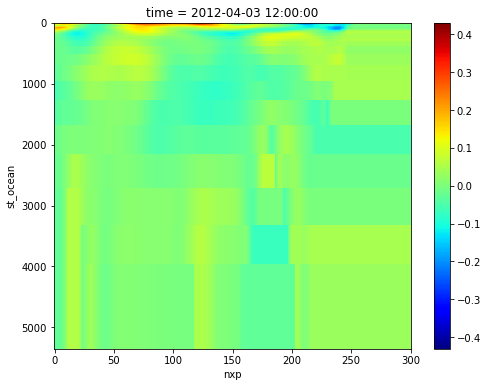

In [134]:

drowned_v_south.isel(time=0).plot(figsize=[8, 6], yincrease=False, cmap='jet')

### adding dim

In [135]:
#n_west_array = np.expand_dims(drowned_u_west.values,axis=3)

n_south_array = np.expand_dims(drowned_v_south.values,axis=2)

In [13]:
west_final = xr.Dataset({
    "u" : (["time","zl","yh","xq"],n_west_array),},
    coords = {"time":(["time",],drowned_u_west.time.values),
              "zl":(["zl",],drowned_u_west.st_ocean.values),
              "yh":(["yh",],drowned_u_west.lat.values),
              "xq":(["xq"],[drowned_u_west.lon.values[0]])})



In [136]:

south_final = xr.Dataset({
    "v" : (["time","zl","yq","xh"],n_south_array),},
    coords = {"time":(["time",],drowned_v_south.time.values),
              "zl":(["zl",],drowned_v_south.st_ocean.values),
              "yq":(["yq",],[drowned_v_south.lat.values[0]]),
              "xh":(["xh"],drowned_v_south.lon.values)})

In [137]:
south_final

<xarray.Dataset>
Dimensions:  (time: 1122, zl: 58, yq: 1, xh: 301)
Coordinates:
  * time     (time) object 2012-04-03 12:00:00 ... 2015-04-29 12:00:00
  * zl       (zl) float64 0.5 1.5 2.5 3.5 4.5 ... 3e+03 3.625e+03 4.3e+03 5e+03
  * yq       (yq) float64 4.0
  * xh       (xh) float64 77.0 77.07 77.15 77.22 ... 98.78 98.85 98.93 99.0
Data variables:
    v        (time, zl, yq, xh) float32 0.1541 0.1651 0.1758 ... -0.0206 -0.0206

In [138]:
#west_final.to_netcdf(exp_dir+"section_west2.nc")


#south_final.to_netcdf(exp_dir+"section_south2.nc")

caops_dir = "/home/nma/HDD_data/vinay/archives/IOMOM5Op/caops/"
sam_obc = xr.open_dataset(caops_dir+"obc_east.nc")
dz = sam_obc.dz_u_segment_002
dirv = "/home/nma/mom/MOM6dev/prepro/obc/gen_vgrid/"
IC_grid = xr.open_dataset(dirv+"2013_final.nc")
hy_depth = IC_grid.DEPTH.values
sam_obc

<xarray.Dataset>
Dimensions:             (xh: 1, yh: 192, xq: 1, yq: 193, zl: 40, time: 34)
Coordinates:
  * xh                  (xh) float64 -77.04
  * yh                  (yh) float64 18.09 18.17 18.24 ... 31.76 31.82 31.89
  * xq                  (xq) float64 -77.08
  * yq                  (yq) float64 18.05 18.13 18.21 ... 31.79 31.86 31.93
  * zl                  (zl) float64 40.0 9.969e+36 ... 9.969e+36 9.969e+36
  * time                (time) datetime64[ns] 2014-12-31T12:00:00 ... 2015-02...
Data variables: (12/13)
    u_segment_002       (time, zl, yh, xq) float64 ...
    v_segment_002       (time, zl, yq, xh) float64 ...
    ssh_segment_002     (time, yh, xh) float64 ...
    dz_u_segment_002    (time, zl, yh, xq) float64 ...
    dz_v_segment_002    (time, zl, yq, xh) float64 ...
    pt_segment_002      (time, zl, yh, xh) float64 ...
    ...                  ...
    dz_pt_segment_002   (time, zl, yh, xh) float64 ...
    dz_s_segment_002    (time, zl, yh, xh) float64 ...
    u11_segment_002     (time, zl, yh, xq) float64 ...
    v11_segment_002     (time, zl, yq, xh) float64 ...
    dz_u11_segment_002  (time, zl, yh, xq) float64 ...
    dz_v11_segment_002  (time, zl, yq, xh) float64 ...

In [139]:
south_obc = south_final
cur_depth = south_obc.zl.values

reg_south_obc = south_obc.interp(zl=hy_depth)

v_south_dz_new = np.array(len(reg_south_obc.xh.values)*[np.array(len(reg_south_obc.yq.values)*[np.array(len(reg_south_obc.time.values)*[np.insert(np.diff(hy_depth),
                                                                                      0,1)])])])

final_dzvs = v_south_dz_new.transpose(2,3,1,0)
fin_reg_south = reg_south_obc.assign({"dz_v":(["time","zl","yq","xh"],final_dzvs)})

tfil_reg_south_obc = fin_reg_south.sel(time=slice("2012-01-01", "2013-12-31"))

final_tfil = tfil_reg_south_obc.rename({"v":"v_segment_001"})

final_tfil.indexes['time']


CFTimeIndex([2012-04-03 12:00:00, 2012-04-04 12:00:00, 2012-04-05 12:00:00,
             2012-04-06 12:00:00, 2012-04-07 12:00:00, 2012-04-08 12:00:00,
             2012-04-09 12:00:00, 2012-04-10 12:00:00, 2012-04-11 12:00:00,
             2012-04-12 12:00:00,
             ...
             2013-12-22 12:00:00, 2013-12-23 12:00:00, 2013-12-24 12:00:00,
             2013-12-25 12:00:00, 2013-12-26 12:00:00, 2013-12-27 12:00:00,
             2013-12-28 12:00:00, 2013-12-29 12:00:00, 2013-12-30 12:00:00,
             2013-12-31 12:00:00],
            dtype='object', length=638, calendar='noleap', freq='D')

In [140]:
final_tfil.to_netcdf("/home/nma/mom/MOM6dev/prepro/obc/obcmar/south_only.nc")